# Pump it Up: Data Mining the Water Table

By: Ville Heilala, https://heila.la

Datasource: http://taarifa.org/, http://maji.go.tz/, https://www.drivendata.org

Goal is to predict the operating condition of a waterpoint for each record in the dataset.

##  Explore the data

In [442]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.0 |Anaconda 4.3.1 (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Pandas version 0.19.2
Matplotlib version 2.0.0


In [445]:
######################
# Load data
##################################################################

# Read data
train_values = pd.read_csv("/train_values.csv")
train_labels = pd.read_csv("/train_labels.csv")
test_values = pd.read_csv("/test_values.csv")

# Add binary variables for train set and test values
train_values["train"] = True
test_values["test"] = True

# Merge train values and test values
data = pd.concat([train_values, test_values], ignore_index = True)

# Merge train labels
data = pd.merge(data, train_labels, on="id", how="outer")

In [198]:
def explore(data):
    df = pd.DataFrame()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isnull(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        dtypes = ", ".join(data[col].map(lambda val: val.__class__.__name__).unique())
        df = df.append(pd.DataFrame([col,
                                     dtypes,
                                     len(unique_values),
                                     nans,
                                     zeros,
                                     unique_values[:5],
                                     unique_values[-5:]]).T,
                       ignore_index = True)
    return df.rename(columns = {0: "variable",
                                1: "dtypes",
                                2: "unique_values",
                                3: "Nan %",
                                4: "zeros %",
                                5: "first_5",
                                6: "last_5"})

data.shape
explore(data)

(74250, 43)

,variable,dtypes,unique_values,Nan %,zeros %,first_5,last_5
0,amount_tsh,float,102,0,70.1,"[0.0, 0.2, 0.25, 0.5, 1.0]","[138000.0, 170000.0, 200000.0, 250000.0, 35000..."
1,basin,str,9,0,0,"[Internal, Lake Nyasa, Lake Rukwa, Lake Tangan...","[Lake Victoria, Pangani, Rufiji, Ruvuma / Sout..."
2,construction_year,int,55,0,35,"[0, 1960, 1961, 1962, 1963]","[2009, 2010, 2011, 2012, 2013]"
3,date_recorded,str,369,0,0,"[2001-03-26, 2002-10-14, 2004-01-04, 2004-01-0...","[2013-11-02, 2013-11-03, 2013-12-01, 2013-12-0..."
4,district_code,int,20,0,0,"[0, 1, 2, 3, 4]","[60, 62, 63, 67, 80]"
5,extraction_type,str,18,0,0,"[afridev, cemo, climax, gravity, india mark ii]","[other - swn 81, submersible, swn 80, walimi, ..."
6,extraction_type_class,str,7,0,0,"[gravity, handpump, motorpump, other, rope pump]","[motorpump, other, rope pump, submersible, win..."
7,extraction_type_group,str,13,0,0,"[afridev, gravity, india mark ii, india mark i...","[other motorpump, rope pump, submersible, swn ..."
8,funder,"str, float",2141,6.1,0,"[Roman, Grumeti, Lottery Club, Unicef, Action ...","[Canaco, Banane, Nyamigogo, Village Fou, Velem]"
9,gps_height,int,2456,0,34.5,"[-90, -63, -59, -57, -56]","[2626, 2627, 2628, 2770, 2777]"


### amount_tsh

Total static head (amount water available to waterpoint)

* Categorical variable with 102 unique values ranging 0 - 350 000
* 70 % of the values are zero, which can be considered missing values
* 50 % of the available true values are small < 250 and only few (22) large values > 50 000

TODO: Imputate missing values, make log, scale [0, 1]

count     74250.000000
mean        318.685704
std        2906.762364
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

0.0       52049
500.0      3874
50.0       3103
1000.0     1858
20.0       1812
200.0      1516
100.0      1034
10.0        995
Name: amount_tsh, dtype: int64

count     22201.000000
mean       1065.826474
std        5240.480449
min           0.200000
25%          50.000000
50%         250.000000
75%        1000.000000
max      350000.000000
Name: amount_tsh, dtype: float64

22

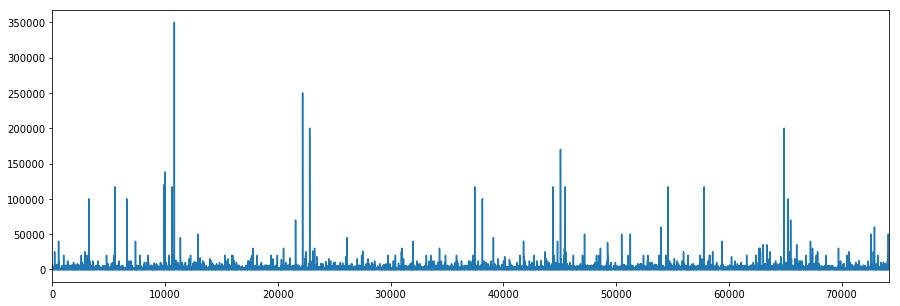

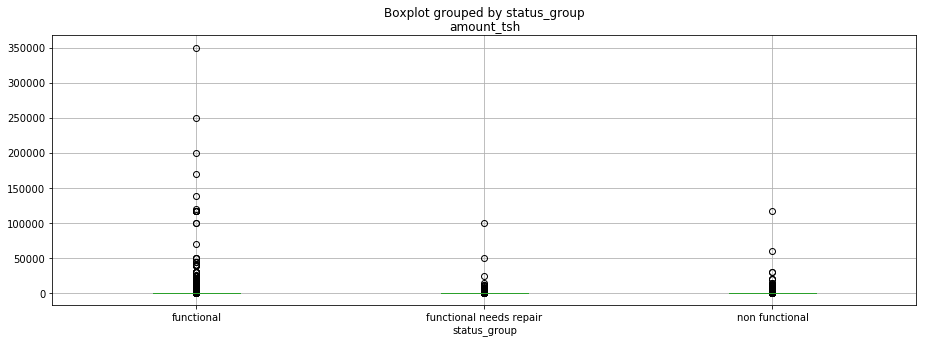

In [5]:
#Describe whole data
data.amount_tsh.describe()
#Plot whole data
data.amount_tsh.plot(figsize=(15,5))
#Top 10 value counts
data.amount_tsh.value_counts()[:10]
#Describe excluding missing data
data.amount_tsh[data.amount_tsh != 0].describe()
#Boxplot grouped by status_group
data[data.train == True].boxplot("amount_tsh", by="status_group", figsize=(15,5))
len(data.amount_tsh[data.amount_tsh > 50000])

## basin

This variable describes a dreinage basin, which is a topographic region in which all water drains to a common area.

![Tanzania water basins](http://file.scirp.org/Html/12-2800526/7f87cbf8-612e-493d-a581-7b67e717fe3d.jpg "Tanzania water basins")

Picture: P. M. Ndomba (2013): [Validation of PSIAC Model for Sediment Yields Estimation in Ungauged Catchments of Tanzania](http://file.scirp.org/Html/12-2800526_37317.htm)

* Basin contains 9 unique values, which can be found also in the map
    * Lake Nyasa (=LNB)
    * Lake Victoria (=LVB)
    * Pangani (=PB)
    * Ruvuma / Southern Coast (=RB)
    * Internal (=LEB)
    * Lake Tanganyika (=LTB)
    * Wami / Ruvu (=WB)
    * Rufiji (=RJB)
    * Lake Rukwa (=LRB)
    
TODO: one-hot encode

In [6]:
data.basin.unique()

array(['Lake Nyasa', 'Lake Victoria', 'Pangani', 'Ruvuma / Southern Coast',
       'Internal', 'Lake Tanganyika', 'Wami / Ruvu', 'Rufiji', 'Lake Rukwa'], dtype=object)

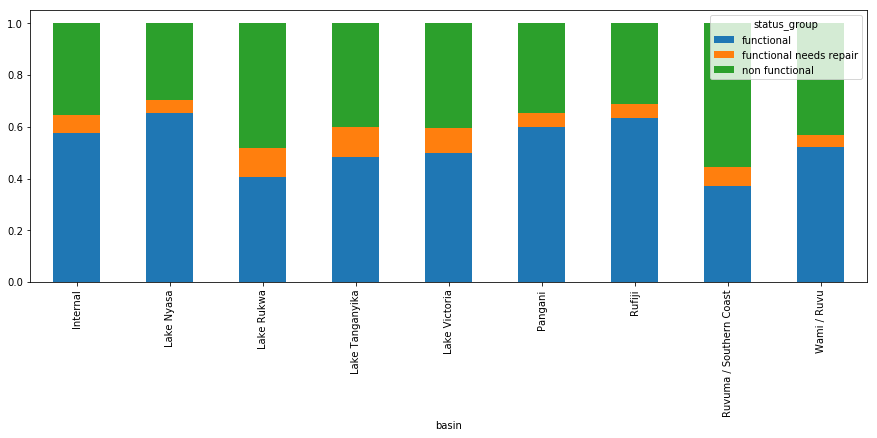

In [7]:
pd.crosstab(data.basin, data.status_group, normalize="index").plot.bar(stacked=True, figsize=(15,5));

## construction_year

Year the waterpoint was constructed

* Years 1960-2013
* 35 % missing values (0)

TODO: Imputate missing values, scale [0, 1]

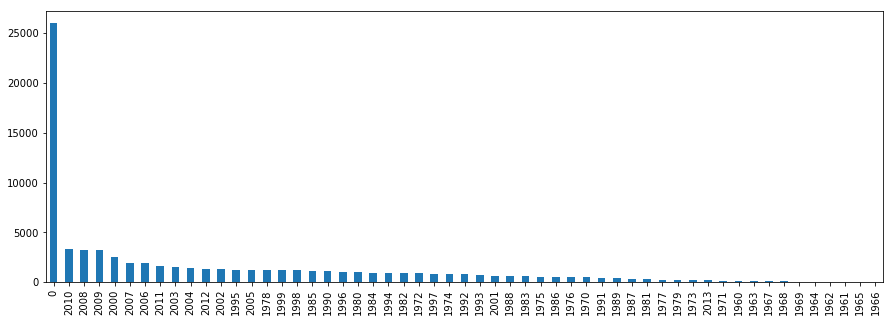

In [8]:
data.construction_year.value_counts().plot.bar(figsize=(15,5));

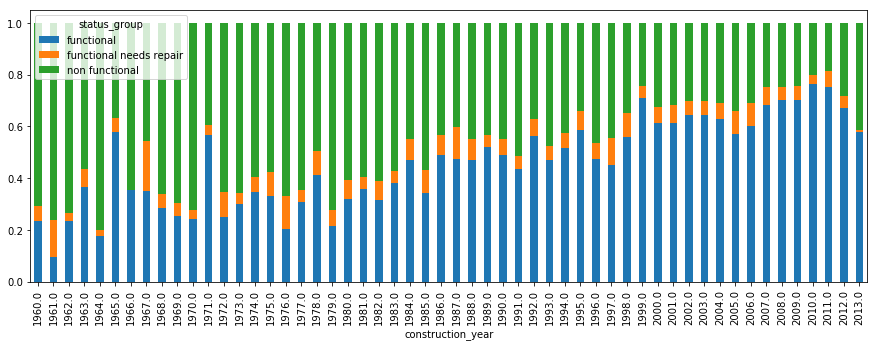

In [9]:
pd.crosstab(data.construction_year[data.construction_year != 0],
            data.status_group, normalize="index").plot.bar(stacked=True, figsize=(15,5));

## date_recorded

The date the row was entered

* Data collection is done between '2001-03-26' - '2013-12-03' (369 different days)
* Majority of the data has been collected between 2011 - 2013

TODO: -

array(['2001-03-26', '2013-12-03'], dtype=object)

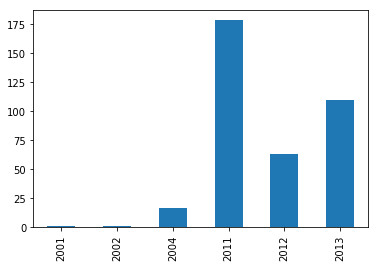

In [10]:
np.sort(data.date_recorded.unique())[[0, -1]]
years = [int(y[0:4]) for y in data.date_recorded.unique()]
pd.DataFrame(years)[0].value_counts(sort=False).plot.bar()

## district_code

* 20 unique categorical values
* Majority of wells are located in areas with district_code 1-4
* Plotting showed some strange latitude and longitude values

TODO: one-hot encode

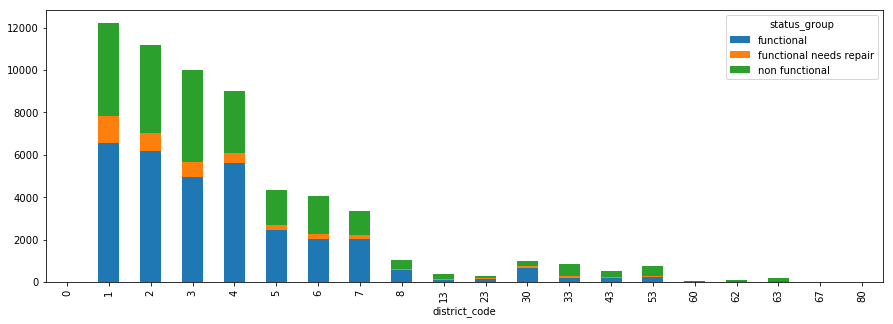

In [11]:
pd.crosstab(data.district_code, data.status_group).plot.bar(stacked=True, figsize=(15,5));

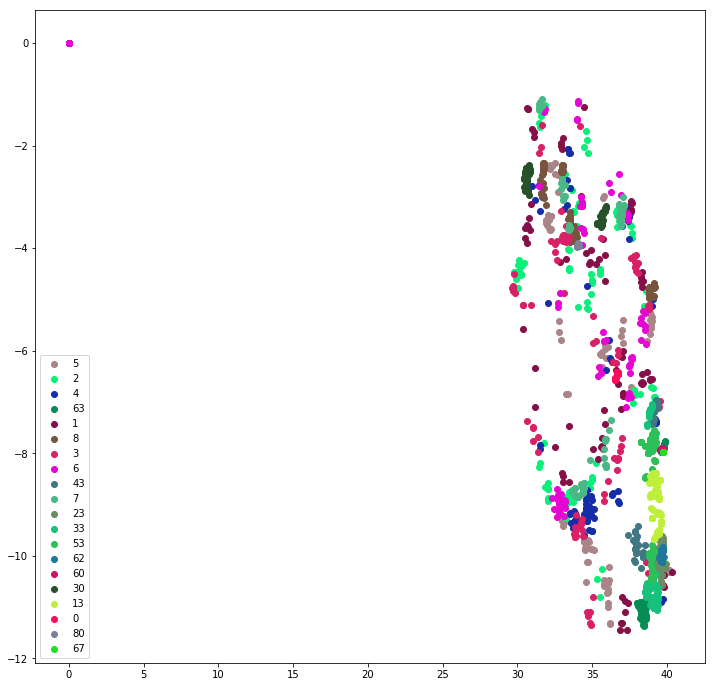

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
for d in data.district_code.unique():
    ax.scatter(data[data.district_code == d][:100]["longitude"],
               data[data.district_code == d][:100]["latitude"], color=np.random.rand(3,))

ax.legend(data.district_code.unique())
plt.show();

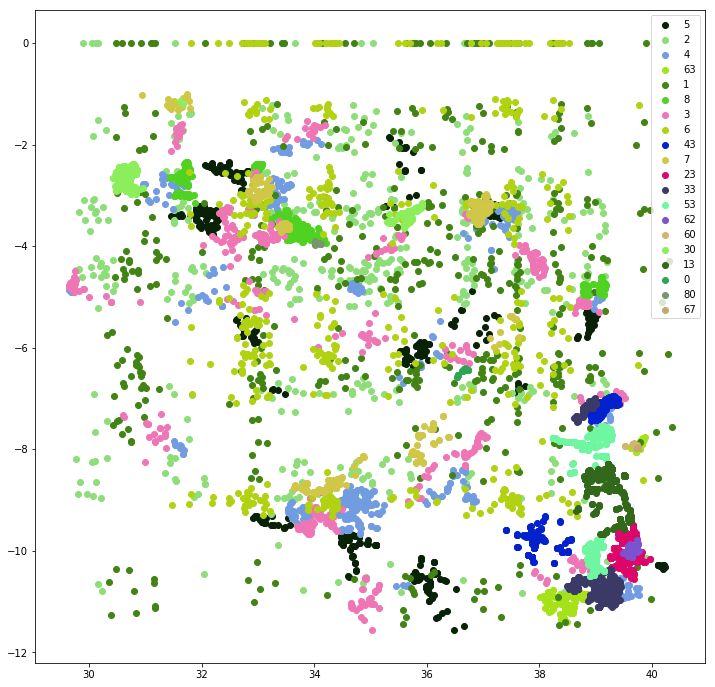

In [113]:
fig, ax = plt.subplots(figsize=(12,12))
for d in data.district_code.unique():
    ax.scatter(data[(data.district_code == d) & (data.longitude != 0)][:500]["longitude"],
               data[data.district_code == d][:500]["latitude"], color=np.random.rand(3,))

ax.legend(data.district_code.unique())
plt.show();

/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


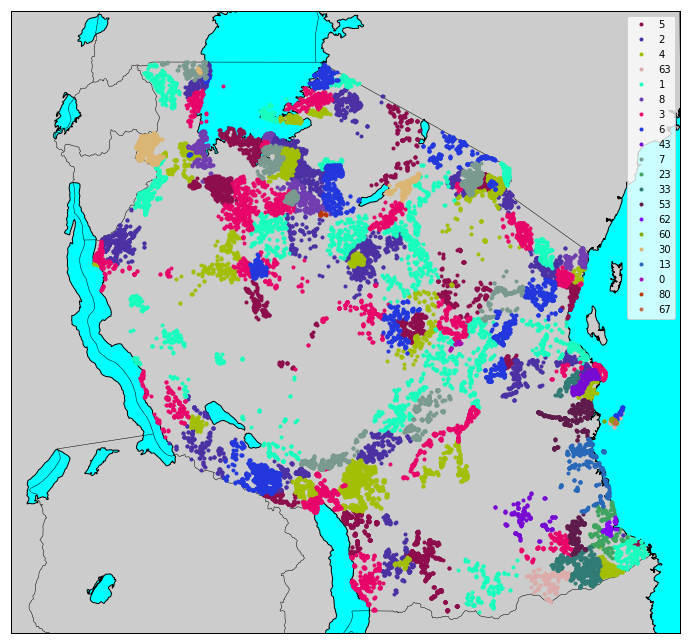

In [120]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(12,12))

my_map = Basemap(projection='merc', lat_0=-6, lon_0=34.5,
    resolution = 'h', area_thresh = 500.0,
    llcrnrlon=28, llcrnrlat=-12,
    urcrnrlon=41, urcrnrlat=0)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary(fill_color="aqua")
my_map.fillcontinents(lake_color="aqua")

for d in data.district_code.unique():
    x,y = my_map(data[data.district_code == d][:5000]["longitude"].values,
                 data[data.district_code == d][:5000]["latitude"].values)
    my_map.plot(x, y, 'ro', markersize=3, color=np.random.rand(3,), label=str(d))

plt.legend()
plt.show();

## extraction_type, extraction_type_class, extraction_type_group

The kind of extraction the waterpoint uses

* 3 variables describe extraction type and there's some redundancy
* Majority of the pumps are gravity (33 263) or handpumps (20 612)
* Gravity, rope and hand pumps seem to be most reliable

TODO: one-hot encode, selection
       
### Gravity

<img src="http://www.solutionmus.org/wp-content/uploads/2014/04/water-services-pemba-tanzania.jpg" width="500"/>
<center>A gravity system provides water to a Maasai community living in Morogoro Region, Tanzania. (http://www.solutionmus.org)</center>

### Handpumps

#### Afridev

<img src="http://sustainablewaterpumps.weebly.com/uploads/9/2/4/3/9243359/3456221_orig.jpeg" width="200"/>
<center>Woman using Afridev pump ([RWSN](http://www.rural-water-supply.net/en/resources/details/345), 2011).</center>

#### Walimi
![Walimi hand pump](http://www.rural-water-supply.net/_ressources/images/default/260/WALIMI_Hand-Book-for-Water-Users_Ed-2002.jpg)

#### India mark ii

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a1/IndiamarkII.jpg/1200px-IndiamarkII.jpg" width="200"/>
<center>(Wikipedia)</center>

#### Nira/Tanira

<img src="http://www.tanira-pumps.com/images/NIRA-AF85_woman.jpg" width="200"/>
<center>(www.tanira-pumps.com)</center>

#### Ksb

<img src="https://www.ksb.com/blob/154/2854e0fa00ac151def0d670479c52596/upa-12-zoll-pic-data.jpg" width="200"/>
<center>(www.ksb.com)</center>


In [127]:
data.extraction_type.unique()

array(['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii',
       'other', 'ksb', 'mono', 'windmill', 'afridev', 'other - rope pump',
       'india mark iii', 'other - swn 81', 'other - play pump', 'cemo',
       'climax', 'walimi', 'other - mkulima/shinyanga'], dtype=object)

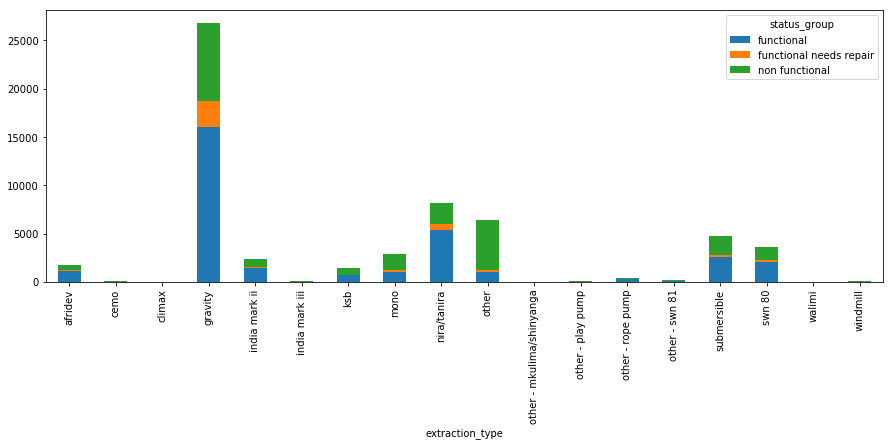

In [157]:
pd.crosstab(data.extraction_type, data.status_group).plot.bar(stacked=True, figsize=(15,5));

In [156]:
pd.crosstab(data.extraction_type, data.extraction_type_class, margins=True)

extraction_type_class,gravity,handpump,motorpump,other,rope pump,submersible,wind-powered,All
extraction_type,,,,,,,,
afridev,0,2208,0,0,0,0,0,2208
cemo,0,0,108,0,0,0,0,108
climax,0,0,41,0,0,0,0,41
gravity,33263,0,0,0,0,0,0,33263
india mark ii,0,3029,0,0,0,0,0,3029
india mark iii,0,135,0,0,0,0,0,135
ksb,0,0,0,0,0,1790,0,1790
mono,0,0,3628,0,0,0,0,3628
nira/tanira,0,10205,0,0,0,0,0,10205


In [155]:
pd.crosstab(data.extraction_type_group, data.extraction_type_class, margins=True)

extraction_type_class,gravity,handpump,motorpump,other,rope pump,submersible,wind-powered,All
extraction_type_group,,,,,,,,
afridev,0,2208,0,0,0,0,0,2208
gravity,33263,0,0,0,0,0,0,33263
india mark ii,0,3029,0,0,0,0,0,3029
india mark iii,0,135,0,0,0,0,0,135
mono,0,0,3628,0,0,0,0,3628
nira/tanira,0,10205,0,0,0,0,0,10205
other,0,0,0,8102,0,0,0,8102
other handpump,0,447,0,0,0,0,0,447
other motorpump,0,0,149,0,0,0,0,149


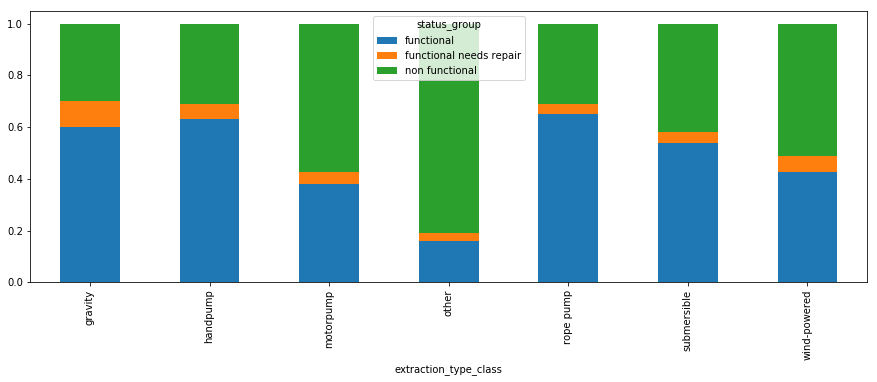

In [160]:
pd.crosstab(data.extraction_type_class,
            data.status_group, normalize="index").plot.bar(stacked=True, figsize=(15,5));

## funder

Who funded the well

* 2141 unique values, 6 % missing NaN values and also other missing values (0)
* Name variation, same funder can be under different names, ex. "Finland Government", "Finland", "Finland Government Finland Gov"
* Within the group of 16 largest funders, pumps funded by private individual and Germany Repoblic are working most reliably.
* DWSP (Domestic Water Supply Programme) has many pumps in category "functional needs repair"

TODO: imputate missing values, unify names, group, one-hot encode

### Funders

* [Danida (Denmark in Tanzania, Ministry of Foreign Affairs of Denmark)](http://tanzania.um.dk/en/danida-en/)
* [Dhv (Royal HaskoningDHV, Netherlands)](https://www.royalhaskoningdhv.com/en-gb/about-us/135-years-royal-haskoningdhv/iconic-projects-water)
* [District Council](https://en.wikipedia.org/wiki/Districts_of_Tanzania)
* [Dwsp, The Domestic Water Supply Program, 1993-2002](https://www.oecd.org/countries/tanzania/42401172.pdf), "The DWSP was the longest running programme in the 35 years of Netherlands support to water and sanitation in Shinyanga, and its approach and achievements underpin much of the work that has been done since."
* GoT (not Game of Thrones, but [Government of Tanzania](https://www.maji.go.tz/?q=en))
* [Health Through Sanitation and Water (HESAWA) Tanzania](http://www.vcn.bc.ca/citizens-handbook/unesco/most/africa7.html) "The HESAWA programme began in 1985 on the basis of a Specific Agreement between Tanzania and Sweden on cooperation concerning rural water supply, environmental sanitation and health education. The programme area covers the Lake Zone, made up of Kagera, Mara and Mwanza regions, which border Lake Victoria."
* Kanisa la Kiinjili la Kilutheri Tanzania (KKKT) ([Evangelical Lutheran Church in Tanzania (ELCT)](https://en.wikipedia.org/wiki/Evangelical_Lutheran_Church_in_Tanzania)) "[ELCT](http://www.elct.org/) has a number of water projects as well as poverty alleviation and environment protection projects. The implementation of these projects have had a significant impact on development in the communities."
* [Rural Water Supply and Sanitation Programme](https://www.oecd.org/countries/tanzania/42401172.pdf) (RWSSP I 1988-1993, [RWSSP II](https://www.afdb.org/fileadmin/uploads/afdb/Documents/Environmental-and-Social-Assessments/FINAL ESMP Report for TZ- RWSSP II - 17 June 2010.pdf) 2002-2006)
* [The Tanzania Social Action Fund (TASAF)](http://www.tasaf.go.tz/)
* [Unicef](https://www.unicef.org/tanzania/wes.html)
* [World Bank](http://projects.worldbank.org/search?lang=en&searchTerm=tanzania)
* [World Vision](http://www.wvi.org/tanzania/our-work)
* [Norad](http://www.eldis.org/go/home&id=43220&type=Document#.WRQk_cklGRs) Norwegian Agency for Development Cooperation
* [Germany Republic](http://www.daressalam.diplo.de/Vertretung/daressalam/en/05/Wirtschaftliche__Zusammenarbeit/water__supply__and__sanitation/seite__water.html)

In [210]:
# Missing values
pd.isnull(data.funder).sum()
len(data.funder[data.funder == "0"])

4504

980

In [382]:
data[pd.isnull(data.funder)]

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,...,source_type,subvillage,test,train,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name,status_group
34,0.0,Rufiji,0,2011-02-23,63,nira/tanira,handpump,nira/tanira,NaN,-41,...,shallow well,Kilombero B,NaN,True,Baleni,salty,hand pump,hand pump,Msikitini Wa Ijumaa,functional
43,0.0,Internal,1980,2013-01-15,2,mono,motorpump,mono,NaN,1642,...,borehole,Mwarufyu,NaN,True,Merya,unknown,communal standpipe,communal standpipe,Mvae Primary,non functional
47,0.0,Lake Nyasa,0,2011-07-27,4,gravity,gravity,gravity,NaN,0,...,spring,Mpandapanda,NaN,True,Kiwira,soft,communal standpipe,communal standpipe,Mahakamani,functional
65,0.0,Internal,1970,2013-02-09,2,mono,motorpump,mono,NaN,1415,...,borehole,Mfumbu,NaN,True,Naintiri,unknown,communal standpipe,communal standpipe,Nyambi,non functional
71,0.0,Rufiji,0,2011-03-31,7,gravity,gravity,gravity,NaN,0,...,river/lake,Lembuka,NaN,True,Mawindi,soft,communal standpipe,communal standpipe,Kwa Manyusi Mlilo,non functional
72,0.0,Rufiji,0,2011-04-04,7,gravity,gravity,gravity,NaN,0,...,river/lake,Mapinduzi,NaN,True,Ubaruku,soft,communal standpipe,communal standpipe,Kwa Mzee Mwalongo,non functional
75,0.0,Lake Victoria,0,2011-08-07,6,submersible,submersible,submersible,NaN,0,...,borehole,Umkituri,NaN,True,Kibeta,soft,communal standpipe multiple,communal standpipe,Kwa Jackson,non functional
109,0.0,Lake Nyasa,0,2011-07-12,4,other,other,other,NaN,0,...,river/lake,Ipuguso,NaN,True,Lutebe,soft,communal standpipe,communal standpipe,Kwa Mzee Kaiga,functional
124,0.0,Lake Nyasa,0,2011-04-07,4,gravity,gravity,gravity,NaN,0,...,spring,Busekele,NaN,True,Itete,soft,communal standpipe,communal standpipe,Busekele,functional
126,50.0,Internal,2000,2013-02-14,2,mono,motorpump,mono,NaN,1455,...,borehole,Mosi,NaN,True,Ikungu,soft,communal standpipe,communal standpipe,Aley Mak8Ta,functional


In [428]:
# Example of name variation
data.funder[data.funder.str.contains("Germany", na=False)].unique()
data.funder[data.funder.str.contains("Fin", na=False)].value_counts()

array(['Germany Republi', 'Germany', 'A/co Germany', 'Germany Misionary',
       'Germany Cristians', 'Bingo Foundation Germany',
       'Africa Project Ev Germany', 'Germany Missionary'], dtype=object)

Fini Water                        474
Finw                              281
Fin Water                          98
Finida German Tanzania Govt        62
Finn Water                         41
Finwater                           39
Finland Government                 23
Finland                            21
Finidagermantanzania Govt          13
Finland Government Finland Gov      1
Name: funder, dtype: int64

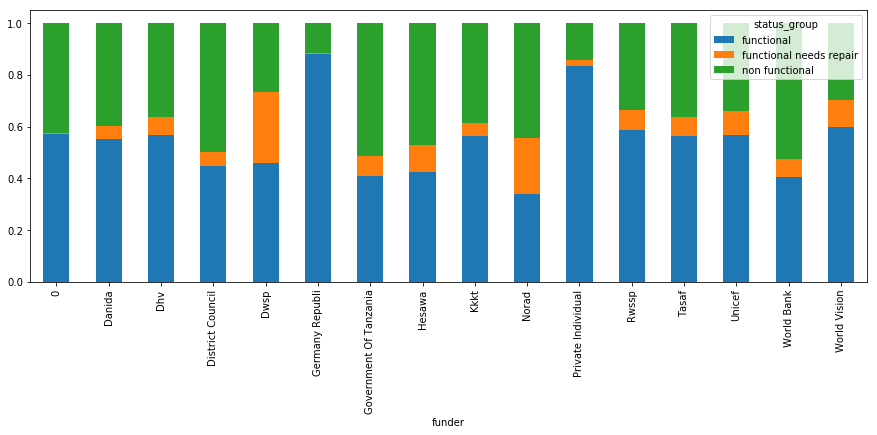

In [413]:
# 13 largest funders
selection = data[data.funder.isin(list(data.funder.value_counts()[:16].keys()))]
pd.crosstab(selection.funder, data.status_group, normalize="index").plot.bar(stacked=True, figsize=(15,5));

array(['Germany Republi', 'Germany', 'A/co Germany', 'Germany Misionary',
       'Germany Cristians', 'Bingo Foundation Germany',
       'Africa Project Ev Germany', 'Germany Missionary'], dtype=object)

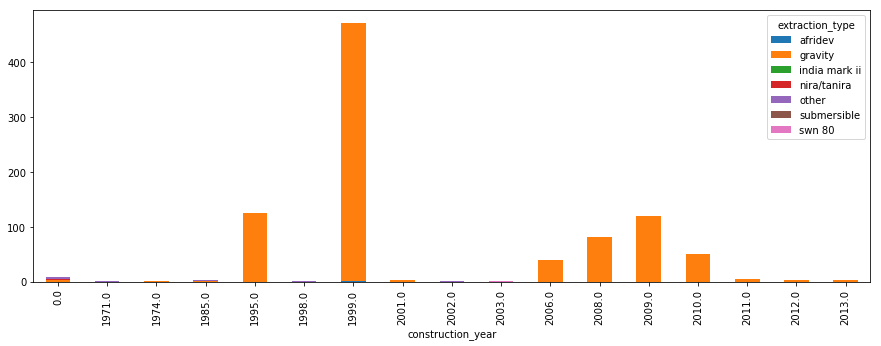

In [447]:
# Funder Germany
data.funder[(data.funder.str.contains("Germany", na=False))].unique()
pd.crosstab(data[(data.funder.str.contains("Germany", na=False))]["construction_year"], 
            data.extraction_type).plot.bar(stacked=True, figsize=(15,5))

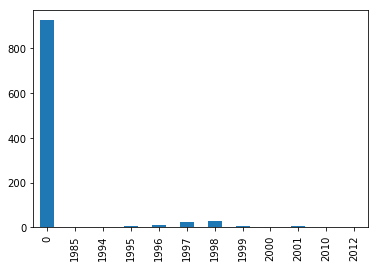

In [387]:
# Funder Dwsp, lot of missing values
data[data.funder.str.contains("Dwsp", na=False)].construction_year.value_counts(sort=False).plot.bar()

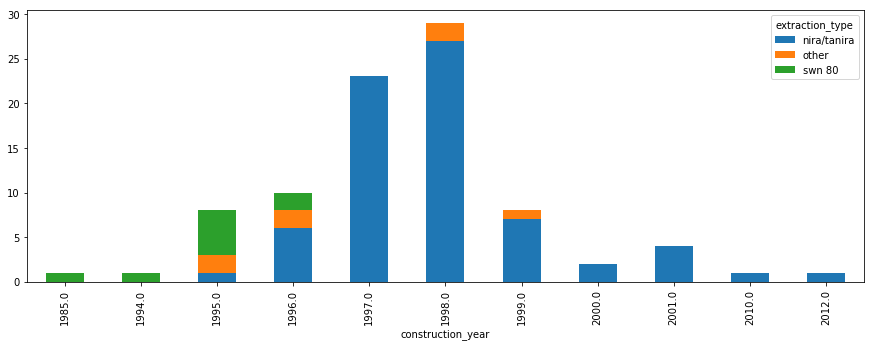

In [449]:
# Funder Dwsp, without missing values, The Domestic Water Supply Program, 1993-2002
pd.crosstab(data[(data.funder == "Dwsp") & (data.construction_year != 0)]["construction_year"], 
            data.extraction_type).plot.bar(stacked=True, figsize=(15,5));

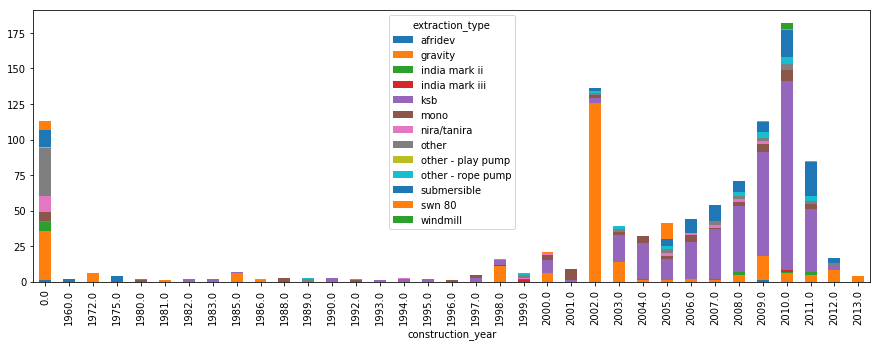

In [418]:
# Private individuals started to install mostly submersible ksb pumps from 2003-
pd.crosstab(data[data.funder == "Private Individual"]["construction_year"],
            data.extraction_type).plot.bar(stacked=True, figsize=(15,5));

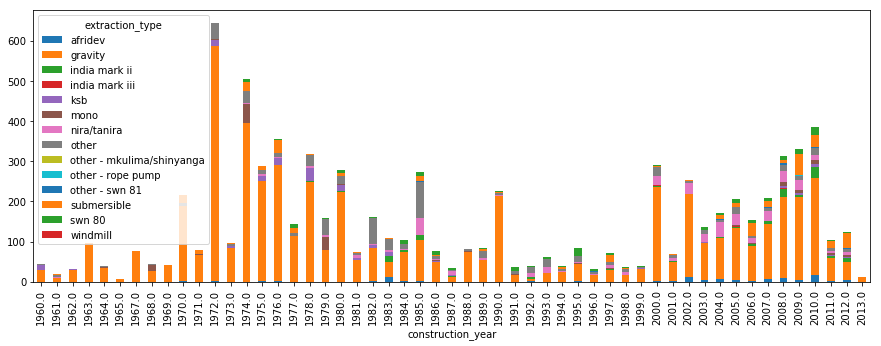

In [416]:
# Government Of Tanzania
pd.crosstab(data[(data.funder == "Government Of Tanzania") & (data.construction_year != 0)]["construction_year"],
            data.extraction_type).plot.bar(stacked=True, figsize=(15,5));

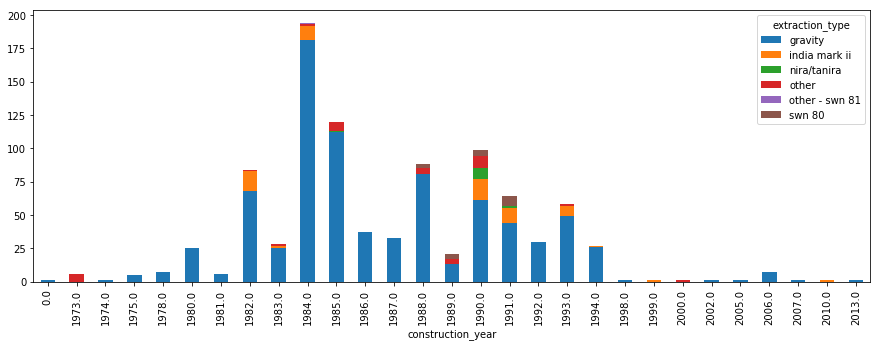

In [414]:
# Norad
pd.crosstab(data[data.funder == "Norad"]["construction_year"],
            data.extraction_type).plot.bar(stacked=True, figsize=(15,5));

array(['Finland', 'Finland Government', 'Finland Government Finland Gov'], dtype=object)

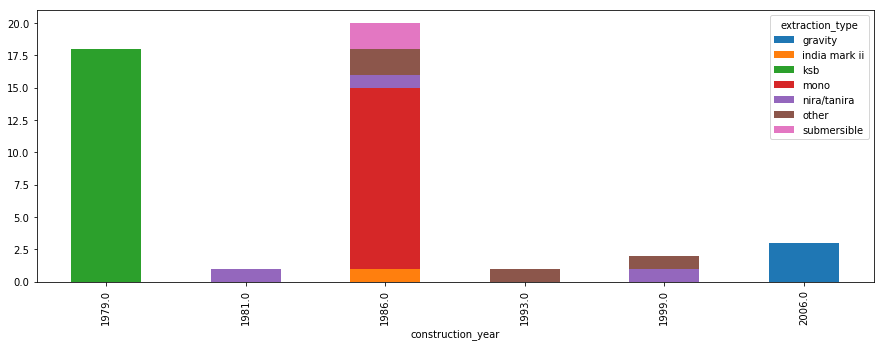

In [450]:
# Finland Government
data.funder[data.funder.str.contains("Finl", na=False)].unique()
pd.crosstab(data[data.funder.str.contains("Finl", na=False)]["construction_year"],
            data.extraction_type).plot.bar(stacked=True, figsize=(15,5))

/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


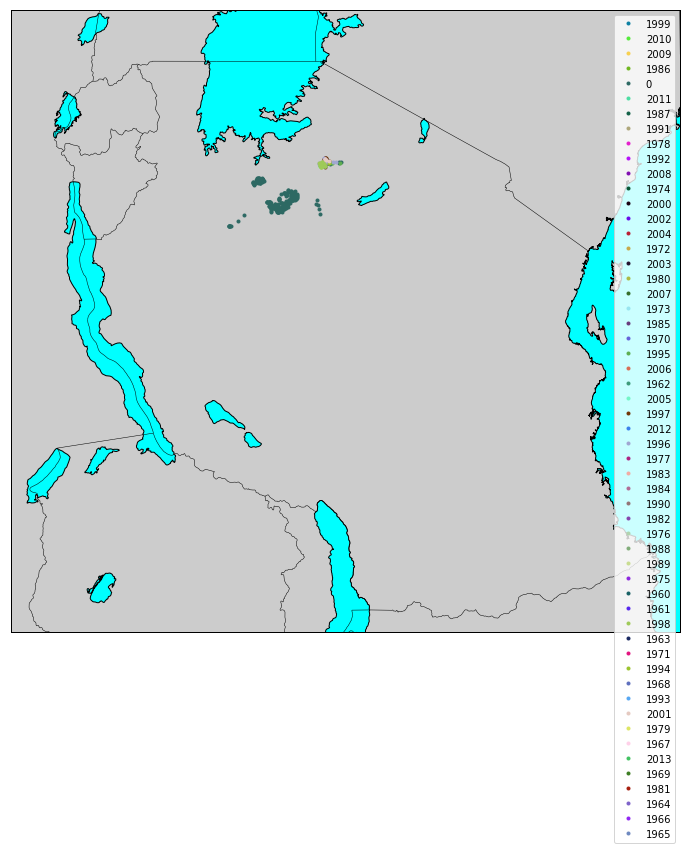

In [453]:
# Imputation of missing construction_year by exploring nearby pumps?
plt.figure(figsize=(12,12))

my_map = Basemap(projection='merc', lat_0=-6, lon_0=34.5,
    resolution = 'h', area_thresh = 500.0,
    llcrnrlon=28, llcrnrlat=-12,
    urcrnrlon=41, urcrnrlat=0)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary(fill_color="aqua")
my_map.fillcontinents(lake_color="aqua")

for d in data.construction_year.unique():
    x,y = my_map(data[(data.construction_year == d) & (data.funder == "Dwsp")][:5000]["longitude"].values,
                 data[(data.construction_year == d) & (data.funder == "Dwsp")][:5000]["latitude"].values)
    my_map.plot(x, y, 'ro', markersize=3, color=np.random.rand(3,), label=str(d))

plt.legend()
plt.show();

## status_group

/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


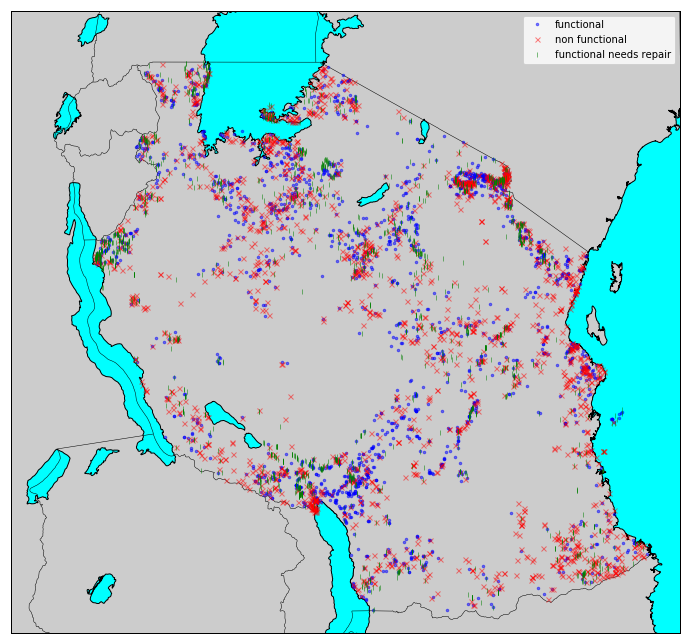

In [520]:
plt.figure(figsize=(12,12))

my_map = Basemap(projection='merc', lat_0=-6, lon_0=34.5,
    resolution = 'h', area_thresh = 500.0,
    llcrnrlon=28, llcrnrlat=-12,
    urcrnrlon=41, urcrnrlat=0)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary(fill_color="aqua")
my_map.fillcontinents(lake_color="aqua")

for d, m, c in zip(data[data.train == True].status_group.unique(), [".", "x", "|"], ["b", "r", "g"]):
    x,y = my_map(data[data.status_group == d][:2000]["longitude"].values,
                 data[data.status_group == d][:2000]["latitude"].values)
    my_map.plot(x, y, m, markersize=5, color=c, label=str(d), alpha=0.5)

plt.legend()
plt.show();